## Feature Engineering
In this part, first we transform the values of `miss_distance` column and perform feature importance analysis.

### Checking the Nature of the column

In [5]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("../data/cleaned_data.csv")
data.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.14,0.394962,0.883161,71745.401048,5.814362e+07,0
1,18.50,0.530341,1.185878,109949.757148,5.580105e+07,1
2,21.45,0.136319,0.304818,24865.506798,6.720689e+07,0
3,20.63,0.198863,0.444672,78890.076805,3.039644e+07,0
4,22.70,0.076658,0.171412,56036.519484,6.311863e+07,0


In [4]:
data['miss_distance'].describe()

count    3.381710e+05
mean     4.153547e+07
std      2.077411e+07
min      6.745533e+03
25%      2.494495e+07
50%      4.332724e+07
75%      5.933961e+07
max      7.479865e+07
Name: miss_distance, dtype: float64

The range of the data is large, from thousands (6.7×1036.7×103) to tens of millions (7.48×1077.48×107).
The data might have a right-skewed distribution because the mean is closer to the 75th percentile than the median.

#### Logarithmic Transformation

Given the wide range of values, a log transformation is highly recommended to compress the scale and handle skewness. Use log1p to avoid issues with very small values (close to 0).

In [6]:
data['miss_distance_log'] = np.log1p(data['miss_distance'])
data

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,miss_distance_log
0,19.140,0.394962,0.883161,71745.401048,5.814362e+07,0,17.878427
1,18.500,0.530341,1.185878,109949.757148,5.580105e+07,1,17.837303
2,21.450,0.136319,0.304818,24865.506798,6.720689e+07,0,18.023286
3,20.630,0.198863,0.444672,78890.076805,3.039644e+07,0,17.229836
4,22.700,0.076658,0.171412,56036.519484,6.311863e+07,0,17.960526
...,...,...,...,...,...,...,...
338166,28.580,0.005112,0.011430,56646.985988,6.406548e+07,0,17.975416
338167,28.690,0.004859,0.010865,21130.768947,2.948883e+07,0,17.199522
338168,21.919,0.109839,0.245607,11832.041031,5.346078e+07,0,17.794459
338169,23.887,0.044377,0.099229,56198.382733,5.184742e+06,0,15.461231


## Implementation

For our problem, we will be first checking the feature importance of each features.


### Method 1: correlation coefficient between the feature and the target variable

In [7]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

In [8]:
# Calculate correlation of each feature with the target variable
correlation_matrix = data.corr()  # Pearson correlation by default
target_corr = correlation_matrix["is_hazardous"]


In [9]:
# Show the correlations with the target variable
print(target_corr)

absolute_magnitude       -0.343996
estimated_diameter_min    0.164841
estimated_diameter_max    0.164841
relative_velocity         0.187034
miss_distance            -0.006542
is_hazardous              1.000000
miss_distance_log         0.009087
Name: is_hazardous, dtype: float64


We may choose to drop the miss_distance feature since its correlation with the target is weak.

### Method 2: Variance Thresholding

In [10]:
# Separate features (X) and target (y)
X = data.drop(columns=['is_hazardous'])
y = data['is_hazardous']

In [11]:
# Initialize VarianceThreshold with a threshold of 0.1 (for example)
selector = VarianceThreshold(threshold=0.1)

# Fit and transform the data to remove low variance features
X_selected = selector.fit_transform(X)

# Get the selected features
selected_feature_names = X.columns[selector.get_support()]

# Show the selected features
print("Selected Features based on Variance Thresholding:", selected_feature_names)


Selected Features based on Variance Thresholding: Index(['absolute_magnitude', 'estimated_diameter_max', 'relative_velocity',
       'miss_distance', 'miss_distance_log'],
      dtype='object')


### Method 3: Recursive Feature Elimination

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Initialize the model (Random Forest Classifier)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the model and the number of features to select
rfe = RFE(estimator=rf)
rfe.fit(X_train, y_train)


RFE(estimator=RandomForestClassifier(random_state=42))

In [15]:
# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['estimated_diameter_min', 'relative_velocity', 'miss_distance'], dtype='object')


### Method 4: Random Forest Feature Importance

In [16]:
# Fits the model on the data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

                  Feature  Importance
3       relative_velocity    0.212383
4           miss_distance    0.179085
5       miss_distance_log    0.178630
0      absolute_magnitude    0.148356
1  estimated_diameter_min    0.145467
2  estimated_diameter_max    0.136079


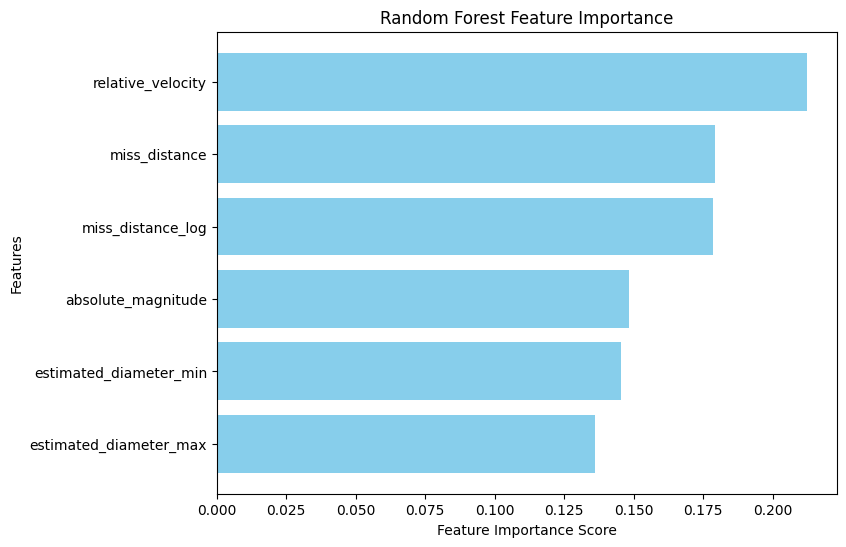

In [17]:
import matplotlib.pyplot as plt

# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Print feature importance
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(8, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()